In [1]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch

import torchvision
import torchvision.transforms as transforms

from torchvision import transforms
from torchvision.datasets import ImageFolder

from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix


# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
transform = transforms.Compose(
    [transforms.Resize((512,512)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 64
#image_size = (224, 224, 3)

train_set = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_33_species/TRAIN/', transform=transform)
test_set = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_33_species/TEST/', transform=transform)

#train_set = train_ds
train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=4)

#test_set = test_ds
test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=False, num_workers=4)

In [3]:
class NewNetwork(nn.Module):
    def __init__(self, num_classes=33):
        super(NewNetwork, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, out_channels = 32, kernel_size=3, stride=2, padding=1), #224
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.1),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),#112
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),#56
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.4)
            #nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=1), #28
            #nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(p=0.5)
            
           
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(4 * 16 * 16, 1000), #mettre 128 quand il y a 5 couches
            nn.PReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1000, 1000),
            nn.PReLU(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [4]:
net = NewNetwork()
net.to(device)

NewNetwork(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): PReLU(num_parameters=1)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): PReLU(num_parameters=1)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.3, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): PReLU(num_parameters=1)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.4, inplace=False)
  )
  (classifier): Sequential

In [5]:
criterion = nn.CrossEntropyLoss()

# also the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#dynamic learning rate
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [6]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

lrs = []
steps = []

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

for epoch in tqdm(range(0, 350)):  # loop over the dataset multiple times
    
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    
    #zone pour mettre le learning rate dynamique
    """
    steps.append(epoch)
    lrs.append(scheduler.get_last_lr()[0])
    scheduler.step()
    """
    
    if epoch % 10 == 0:
        print('\nEpoch: {}'.format(epoch))
        print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))
    
    # evaluate on the test set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the test set
    with T.no_grad():
        correct = 0
        total = 0
        test_running_loss = .0
        for data in test_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Append batch prediction results
            predlist=torch.cat([predlist,predicted.view(-1).cpu()])
            lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

        test_running_loss /= len(test_loader)
        test_loss.append(test_running_loss)
        test_running_acc = correct / total
        test_acc.append(test_running_acc)
        
        if epoch % 10 == 0:
            print('Test Acc.  => {:.3f}%'.format(100 * test_running_acc), end=' | ')
            print('Test Loss  => {:.5f}'.format(test_running_loss))

print('Finished Training')

  0%|          | 0/350 [00:00<?, ?it/s]


Epoch: 0
Train Acc. => 6.397% | Train Loss => 3.48210
Test Acc.  => 9.442% | Test Loss  => 3.45905

Epoch: 10
Train Acc. => 14.287% | Train Loss => 2.97996
Test Acc.  => 13.841% | Test Loss  => 2.93098

Epoch: 20
Train Acc. => 25.435% | Train Loss => 2.41255
Test Acc.  => 25.536% | Test Loss  => 2.38770

Epoch: 30
Train Acc. => 42.792% | Train Loss => 1.79570
Test Acc.  => 40.236% | Test Loss  => 1.86136

Epoch: 40
Train Acc. => 55.772% | Train Loss => 1.38203
Test Acc.  => 48.820% | Test Loss  => 1.61192

Epoch: 50
Train Acc. => 64.748% | Train Loss => 1.09115
Test Acc.  => 59.013% | Test Loss  => 1.28215

Epoch: 60
Train Acc. => 72.686% | Train Loss => 0.82193
Test Acc.  => 62.876% | Test Loss  => 1.10707

Epoch: 70
Train Acc. => 76.304% | Train Loss => 0.68629
Test Acc.  => 71.137% | Test Loss  => 0.89723

Epoch: 80
Train Acc. => 79.328% | Train Loss => 0.60783
Test Acc.  => 72.210% | Test Loss  => 0.83273

Epoch: 90
Train Acc. => 81.697% | Train Loss => 0.52379
Test Acc.  => 73.06

## Visualization

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)


[[15442   925    34 ...     0     0   837]
 [  147 15407    80 ...     0     5   411]
 [  182   215 11470 ...    14    64   536]
 ...
 [   18    21     5 ...  4931   814   128]
 [   19    33    36 ...   866  5975   167]
 [  237    29    37 ...     0     1 27776]]


<AxesSubplot:>

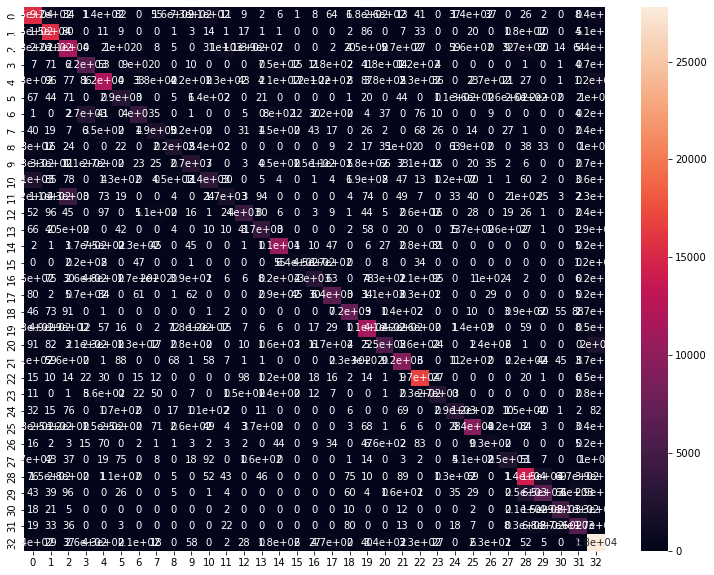

In [9]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(conf_mat, annot=True, ax=ax)

In [10]:
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[74.77966102 93.65957447 69.72644377 67.69230769 72.46808511 58.44897959
 47.89285714 50.62337662 56.46753247 51.23809524 44.45454545 24.68571429
 71.71428571 71.18095238 81.6988417  36.4        40.13605442 67.37566138
 85.26190476 73.41558442 55.90816327 81.96428571 93.85434174 64.78571429
 76.20779221 76.65306122 38.04081633 65.84415584 80.13445378 59.99078341
 78.26984127 68.28571429 90.18181818]


In [11]:
"""
plt.plot(steps, lrs)
plt.xlabel("epoch")
plt.ylabel("learning rate values")
plt.title("learning rate's curve")
plt.show()
"""

'\nplt.plot(steps, lrs)\nplt.xlabel("epoch")\nplt.ylabel("learning rate values")\nplt.title("learning rate\'s curve")\nplt.show()\n'

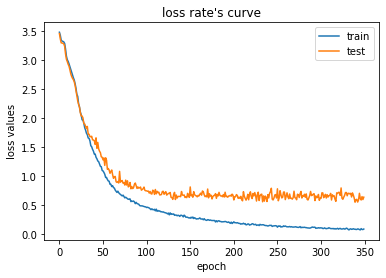

In [12]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.xlabel("epoch")
plt.ylabel("loss values")
plt.title("loss rate's curve")
plt.legend()
plt.show()

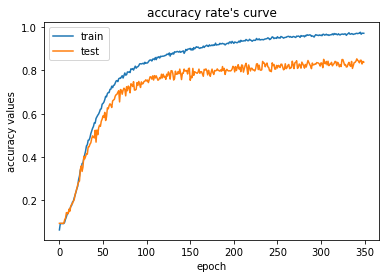

In [13]:
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.xlabel("epoch")
plt.ylabel("accuracy values")
plt.title("accuracy rate's curve")
plt.legend()
plt.show()

In [14]:
#torch.save(net.state_dict(), "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_20-80/dict_Linh_network_1st_try")

In [15]:
#torch.save(net, "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_20-80/Linh_network_entire_model_1st_try")

In [16]:
"""
from torch.utils.data.dataloader import DataLoader


train_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

from torchvision.utils import make_grid

def show_batch(dl):
    #Plot images grid of single batch
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

"""

'\nfrom torch.utils.data.dataloader import DataLoader\n\n\ntrain_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\nfrom torchvision.utils import make_grid\n\ndef show_batch(dl):\n    #Plot images grid of single batch\n    for images, labels in dl:\n        fig,ax = plt.subplots(figsize = (16,12))\n        ax.set_xticks([])\n        ax.set_yticks([])\n        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))\n        break\n        \nshow_batch(train_dl)\n\n'

In [17]:
"""
transform2 = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor()])

train_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_20-80/TRAIN/', transform=transform2)

train_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

        
show_batch(train_dl2)
"""

"\ntransform2 = transforms.Compose(\n    [transforms.Resize((224, 224)),\n     transforms.ToTensor()])\n\ntrain_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_20-80/TRAIN/', transform=transform2)\n\ntrain_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\n        \nshow_batch(train_dl2)\n"